## Evaluating Hyperparameters using Yelp Sentiment Classifier in Keras

Past decade has seen the exponential increase in computational capacity of computers and getting cheaper at the same time. This has lead to the emergence of big data and hence opened new doors to solve problems hungry for the marriage of very large data sets with machine learning algorithms ushering humanity into an era where computers could not only automate mundane tasks and crunch astronomical numbers, but also achieve superhuman skills in recognizing cat from dogs, and classifying them into thousands of breeds all by learning the hidden structures in features of dog vs cat and helping mathematicians write formulas for high energy experiments to find new quantum particles.

Among all things, deep learning has helped pick up slack in computer vision, speech synthesis and machine translation taking the task of careful feature engineering from domain experts and landing it in the hands of mathematicians and software engineers who could build the infrastructure and functions to automatically learn subtle features by looking at numerous samples. 
It has been proved that given the right parameters, a neural network can model any function that can take $x$ as input and output $y$. Learning the right parameters here has now become one of the primitive areas of research since last few years. 

In this blog post, I will try to show the importance of these hyperparameters by comparing their performance on Recurrent Neural Networks. Some of the parameters might not make sense in strict theoretical sense on RNN for e.g. squared_hinge loss but looking at how they affect accuracy and loss will further corrborate that theory. We'll try to see how using different parameters affects *loss* and *accuracy* of a sentiment classifier.

What this blog post is **not**: Geting highest accuracy possible with the maximal generalizability.


## Overview
   1. Download, Import, and Preprocess Dataset
   2. Setup Plots for comparing accuracy and losses
   3. Build and Evaluate a sample Sentiment Classifier 
   4. Evaluate different Hyperparamters on Sentiment Classifier built in Step 3
   
## We'll be evaluating hyperparameters in 6 parts
We'll use a simple sentiment classifier and evaluate it's performance on multiple parameters in a step-wise manner.
    
    A. Activation Function
    B. Cost function
    C. Number of epochs
    D. Gradient Estimation
    E. Network Architectures
    F. Network Initialization
    
We'll try to answer the folllowing two questions for each part.
1. **How changing the hyperparameters effect the accuracy?**
2. **How does it effect how quickly the network plateaus?**


## 1. Download, Import, and Preprocess Dataset

<img src="https://s3-media3.fl.yelpcdn.com/assets/srv0/styleguide/b62d62e8722a/assets/img/brand_guidelines/yelp_fullcolor_outline@2x.png">

Yelp dataset has appropriate amount of reviews posted from people from over 4 continents. <br>
We'll only be using a subset of the big dataset. For more details head to [https://www.yelp.com/dataset/documentation/json](https://www.yelp.com/dataset/documentation/json)

**review.json**

Contains full review text data including the `user_id` that wrote the review and the `business_id` the review is written for.

Total Dataset size: **`3.6GB`** with **`4.7 Million`** reviews 

```json
{
    // string, 22 character unique review id
    "review_id": "zdSx_SD6obEhz9VrW9uAWA",

    // string, 22 character unique user id, maps to the user in user.json
    "user_id": "Ha3iJu77CxlrFm-vQRs_8g",

    // string, 22 character business id, maps to business in business.json
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // integer, star rating
    "stars": 4,

    // string, date formatted YYYY-MM-DD
    "date": "2016-03-09",

    // string, the review itself
    "text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0
}
```

<img src="http://www.bypeople.com/wp-content/uploads/2013/01/MongoDB.jpg">

I always keep the yelp data around in mongoDB for my text analysis experiments.

You can download above dataset and import it into mongoDB with using
```sh
mongoimport -d yelp -c reviews --jsonArray < reviews.json
```

We can also directly load dataset into memory into a *pandas* dataframe using
```python
# Assuming you have data in root directory
reviews = pandas.read_json('reviews.json')
```

In [1]:
from pymongo import MongoClient

In [2]:
client = MongoClient()

In [3]:
db = client.yelp

In [4]:
reviews = db.review

In [5]:
reviews.find_one()

{'_id': ObjectId('5a0f13033f1fccaeb911ce15'),
 'business_id': 'uYHaNptLzDLoV_JZ_MuzUA',
 'cool': 0,
 'date': '2016-07-12',
 'funny': 0,
 'review_id': 'VfBHSwC5Vz_pbFluy07i9Q',
 'stars': 5,
 'text': 'My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\n\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were inc

Seperate *sentiments* based on *stars*
- **negative**: *stars* < 3
- **positive**: *stars* > 3
- **neutral**: *stars* == 3, which we not concerned in this experiment to keep the post succint

Neural network based approaches needs a lot of data to learn, however we are not concerned with state of art accuracy so as long as we provide the same dataset to all our models, we will be able to evaluate just like it would've been on a large dataset.

In [6]:
TOTAL_TRAIN_RECORDS = 1000
TOTAL_DEV_RECORDS = int(TOTAL_TRAIN_RECORDS * .01)
TOTAL_TEST_RECORDS = int(TOTAL_TRAIN_RECORDS * .01)
TOTAL_RECORDS = TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS + TOTAL_TEST_RECORDS

In [7]:
positive_reviews = reviews.find({ 'stars': { '$gt': 3 } }).limit(TOTAL_RECORDS)
negative_reviews = reviews.find({ 'stars': { '$lt': 3 } }).limit(TOTAL_RECORDS)

Whenever you limit the number of records in a mongo query and then later want to verify the count, you would have to use following **with_limit_and_skip** flag to consider the *limit* clause.

In [8]:
positive_reviews.count(with_limit_and_skip=True)

1020

In [9]:
positive_reviews.count()

3123833

In [10]:
negative_reviews.count()

1042245

In [11]:
pos_source, pos_target = [], []
for review in positive_reviews:
    pos_source.append(review['text'])
    pos_target.append(1)
print(len(pos_source), len(pos_target))

1020 1020


In [12]:
neg_source, neg_target = [], []
for review in negative_reviews:
    neg_source.append(review['text'])
    neg_target.append(0)
print(len(neg_source), len(neg_target))

1020 1020


<img src="https://matplotlib.org/_static/logo2.svg">

## 2. Setup Plots for comparing accuracy and losses
Lets define a function that will help us plot accuracy and loss for comparing outcomes of our experiments.

In [13]:
import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

In [35]:
epochs = 20
history = {'loss': np.random.normal(0, 0.1, epochs), 
           'acc': np.random.normal(0, 0.1, epochs), 
           'val_acc': np.random.normal(0, 0.1, epochs), 
           'val_loss': np.random.normal(0, 0.1, epochs)}
title = "Sample Plot"
test_eval = [0, 1]

In [42]:
def print_acc_loss_plot(epochs, history, title, test_eval):
    '''Prints a plot of Accuracy and Loss sharing the same x axis
    :type epochs: int
    :type history: dict: {'loss': list of float, 
                          'acc': list of float, 
                          'val_acc': list of float, 
                          'val_loss': list of float}
    :type title: str
    :type test_eval: list of floats
    '''
    test_loss, test_acc = test_eval
    epochs_axis = np.arange(1, epochs+1)
    
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(2, sharex='row')

    # Two axes that gets attached together horizontally
    # Axis 1: Accuracy
    ax1.plot(epochs_axis, history['acc'], '-', label="Training")
    ax1.plot(epochs_axis, history['val_acc'], '-', label="Validation")
    ax1.set_ylabel("Accuracy")

    title = "{:32}Test Loss:{:.2f}, Accuracy:{:.2f}".format(title, test_loss, test_acc)
    ax1.set_title(title, loc='right')

    # Axis 2: Loss
    ax2.plot(epochs_axis, history['loss'], '-', label="Training")
    ax2.plot(epochs_axis, history['val_loss'], '-', label="Validation")
    ax2.set_xlabel("Number of epochs")
    ax2.set_ylabel("Loss")
    ax2.legend(loc='center right')

    plt.xlim(0, epochs+1)

    plt.subplots_adjust(hspace=0.001)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    plt.show()

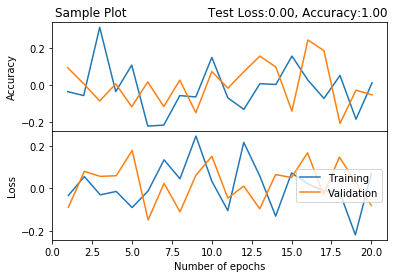

In [43]:
print_acc_loss_plot(epochs, history, title, test_eval)

**Now let's use the `GridSpec` API to create a Grid of the multiple subplots we created above**

> Since these are so many plots, I've only labelled `x axis` to avoid clutter in so many graphs we'll be creating.

In [85]:
def show_grid(epochs, histories, titles, test_evals, megatitle):
    '''Prints a grid of accuracy and loss subplots
    :type epochs: int
    :type histories: list of history
    :type titles: list of str
    :type test_evals: list of list of floats
    :type megatitle: str
    
    1. Create an array of range 1 to the number of epochs
    2. Initialize a figure object
    3. Calculate the grid parameters (rows, cols) based on the number of records
    4. Start a loop and keep adding subplots like print_acc_loss_plot() to the grid
    5. Print the plot
    '''
    epochs_axis = np.arange(1, epochs+1)
    
    fig = plt.figure(figsize=(30,30))
    cols = (len(histories)+1)//3
    rows = (len(histories)+1)//2
    outer = gridspec.GridSpec(rows, cols, wspace=0.01, hspace=0.2)

    for i in range(len(histories)):
        history = histories[i]
        test_loss, test_acc = test_evals[i]
        
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.001)

        # Two axes that gets attached together horizontally
        # Axis 1: Accuracy
        ax1 = plt.Subplot(fig, inner[0])
        ax1.plot(epochs_axis, history['acc'], '-', label="Training")
        ax1.plot(epochs_axis, history['val_acc'], '-', label="Validation")
        if i%cols == 0: 
            ax1.set_ylabel("Accuracy")
        if i%cols != 0: 
            ax1.set_xticks([])
            ax1.set_yticks([])
        titl = "{:150}Test Loss:{:.2f}, Accuracy:{:.2f}".format(titles[i], test_loss, test_acc)
        ax1.set_title(titl, loc="right")
        fig.add_subplot(ax1)
        
        # Axis 2: Loss
        ax2 = plt.Subplot(fig, inner[1])
        ax2.plot(epochs_axis, history['loss'], '-', label="Training")
        ax2.plot(epochs_axis, history['val_loss'], '-', label="Validation")
        ax2.set_xticks(epochs_axis)

        if i%len(histories) == 0:
            ax2.set_xlabel("Number of epochs")
        if i%cols != 0:
            ax2.set_yticks([])
        if i%cols == 0: 
            ax2.set_ylabel("Loss")

        fig.add_subplot(ax2)
    
    plt.legend(bbox_to_anchor=(-cols/2, rows*2.39, cols, .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0., fontsize=25)
    fig.suptitle("Measurements of various " + megatitle.title(), size=25, y=0.935)
    plt.show()

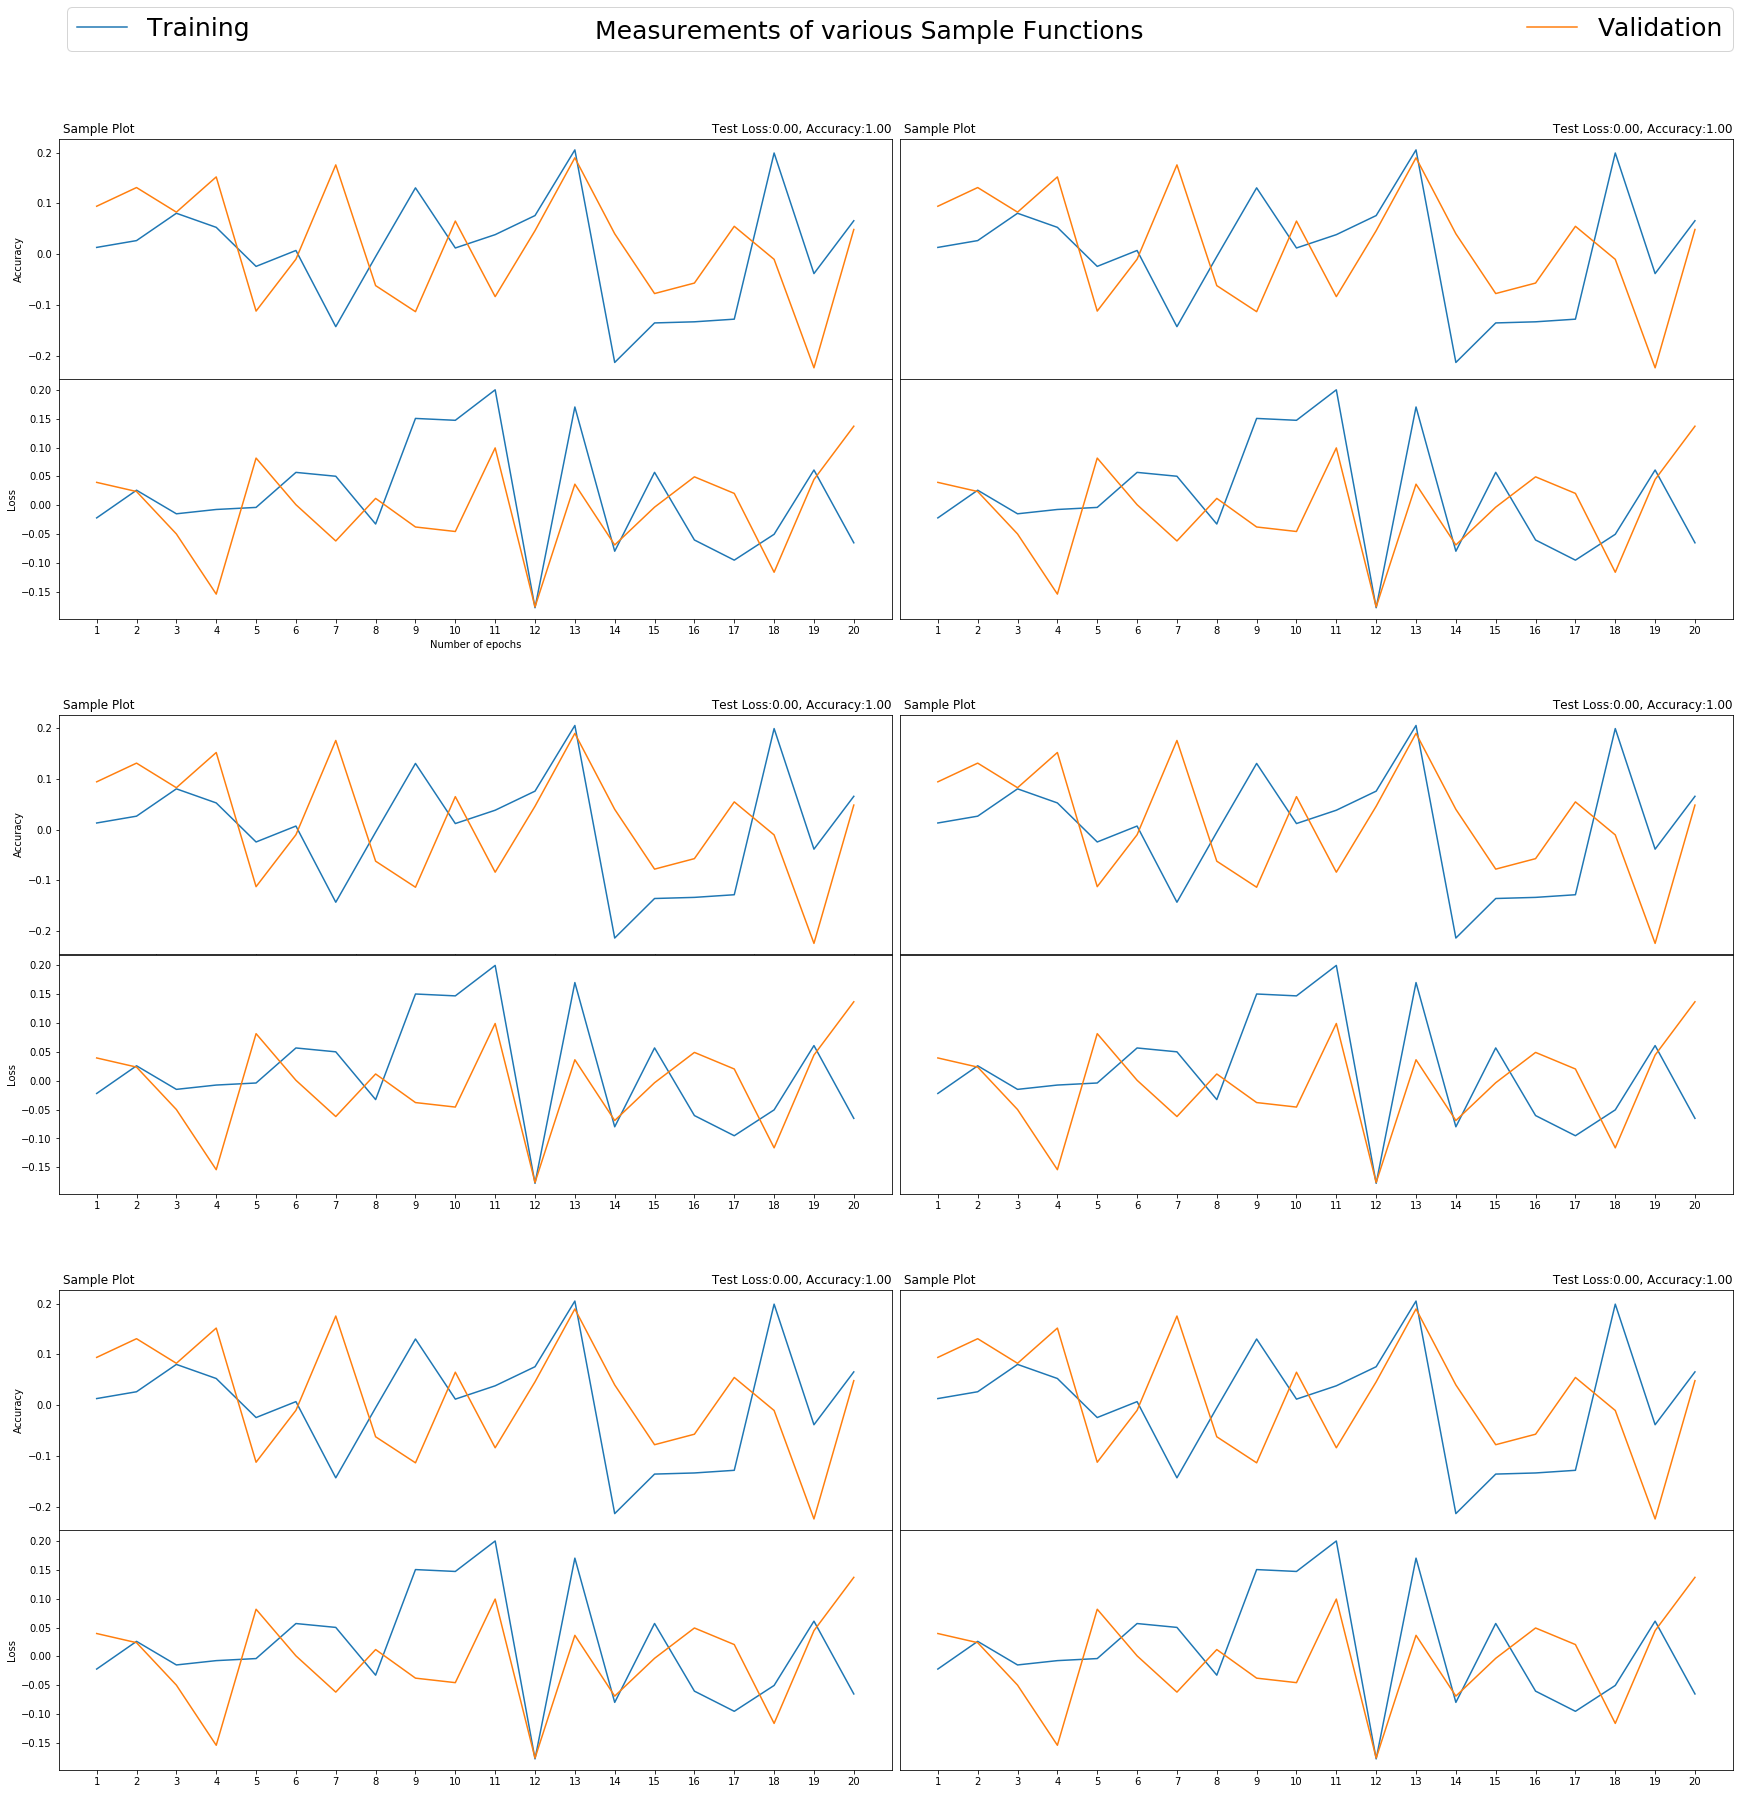

In [18]:
show_grid(epochs, [history]*6, [title]*6, [test_eval]*6, "sample functions")

<img src="https://blog.keras.io/img/keras-tensorflow-logo.jpg">

## 3. Build and Evaluate a sample Sentiment Classifier 
Our sentiment classifer models whether a given text sentence is a *positive* or *negative* sentiment using Keras on tensorflow backend

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Embedding, Lambda, Activation, RepeatVector, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import backend
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [20]:
MAX_VOCABULARY_WORDS = 10000
MAX_SEQUENCE_LENGTH = 10
EMBEDDING_DIM = 10
HIDDEN_UNITS = 512
EPOCHS = 10
BATCH_SIZE = 64
DROPOUT = 0.2
reverse_sentiments = {1: 'POSITIVE', 0: 'NEGATIVE'}

### Load data and convert to index sequence

In [21]:
tokenizer = Tokenizer( num_words=MAX_VOCABULARY_WORDS,
                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                       split=" ",
                       lower=True,
                       char_level=False)

In [22]:
tokenizer.fit_on_texts(pos_source + neg_source)
print("Note: Total Vocabulary is", len(tokenizer.word_index), "but we'll only be using", MAX_VOCABULARY_WORDS)

Note: Total Vocabulary is 12568 but we'll only be using 10000


In [23]:
def preprocess_data(source, target):
    '''Converts a sentence into padded sequence
    1. tokenizer
        - Splits a sentence in words seperated by space 
        - Replaces each word by it's integer index in the vocabulary (tokenizer.word_index)
    2. pad_sequences
        - takes variable lengths sequences from step 1 and convert to constant length: maxlen
        - padding: pre adds padding in before start of sequences
        - truncating: post means elements of sequences longer than maxlen are removed after maxlen elements
    E.g. Input: ['blog on medium is long and hence detailed', 'long blog']
    tokenizer output: [[1, 2, 3, 4, 5, 6, 7, 8], [5, 1]]
    pad_sequences with maxlen=5 output: [[1, 2, 3, 4, 5], [0, 0, 0, 5, 1]]
    
    :type source: list of str
    :type target: list of integer
    :rtype source: numpy array of shape (len(source), MAX_SEQUENCE_LENGTH)
    :rtype target: numpy array of shapre (len(source), 1) each value is either 0 (negative) or 1 (positive) 
    '''
    
    source = tokenizer.texts_to_sequences(source)
    source = pad_sequences(source, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')
    
    return source, np.array(target)

In [24]:
train_set, train_label = preprocess_data(pos_source[:TOTAL_TRAIN_RECORDS] + neg_source[:TOTAL_TRAIN_RECORDS], 
                                         pos_target[:TOTAL_TRAIN_RECORDS] + neg_target[:TOTAL_TRAIN_RECORDS])

validation_set, validation_label = preprocess_data(pos_source[TOTAL_TRAIN_RECORDS:TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS] + 
                                                   neg_source[TOTAL_TRAIN_RECORDS:TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS], 
                                                   pos_target[TOTAL_TRAIN_RECORDS:TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS] + 
                                                   neg_target[TOTAL_TRAIN_RECORDS:TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS])

test_set, test_label = preprocess_data(pos_source[TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS:TOTAL_RECORDS] + 
                                       neg_source[TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS:TOTAL_RECORDS], 
                                       pos_target[TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS:TOTAL_RECORDS] + 
                                       neg_target[TOTAL_TRAIN_RECORDS + TOTAL_DEV_RECORDS:TOTAL_RECORDS])

In [25]:
print("Total number of Training records", train_set.shape)
print("Total number of Validation records", validation_set.shape)
print("Total number of Test records", test_set.shape)

Total number of Training records (2000, 10)
Total number of Validation records (20, 10)
Total number of Test records (20, 10)


### DEEP LEARNING MODEL
- We'll create a Deep Learning model and validate the accuracy.
- The Deep Learning model is a Recurrent Neural Network (RNN) to encode sequential structure of reviews in yelp using LSTM/GRU and single/multiple layers with the last layer of sigmoid to output probability of whether a review is *positive* or *negative*.

#### A. Define network architectures

In [107]:
def get_single_layer_lstm_model(hidden_units=HIDDEN_UNITS, activation='tanh', bidirectional=False):
    model = Sequential()
    model.add(Embedding(MAX_VOCABULARY_WORDS+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    if bidirectional == True:
        model.add(Bidirectional(LSTM(hidden_units, activation=activation)))
    else:
        model.add(LSTM(hidden_units, activation=activation))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation='sigmoid'))
    return model

def get_single_layer_gru_model(hidden_units=HIDDEN_UNITS, activation='tanh', bidirectional=False, initializer='zeros'):
    model = Sequential()
    model.add(Embedding(MAX_VOCABULARY_WORDS+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    if bidirectional == True:
        model.add(Bidirectional(GRU(hidden_units, activation=activation)))
    else:
        model.add(GRU(hidden_units, activation=activation, kernel_initializer=initializer))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation='sigmoid'))
    return model

def get_double_layer_lstm_model(hidden_units=HIDDEN_UNITS, activation='tanh'):
    model = Sequential()
    model.add(Embedding(MAX_VOCABULARY_WORDS+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(hidden_units, activation=activation, return_sequences=True))
    model.add(Dropout(DROPOUT))
    model.add(LSTM(hidden_units, activation=activation))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation='sigmoid'))
    return model

def get_double_layer_bdlstm_model(hidden_units=HIDDEN_UNITS, activation='tanh'):
    # merge_mode can be one of {'sum', 'mul', 'concat', 'ave'}, concat is default
    model = Sequential()
    model.add(Embedding(MAX_VOCABULARY_WORDS+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(Bidirectional(LSTM(hidden_units, activation=activation, return_sequences=True)))
    model.add(Dropout(DROPOUT))
    model.add(Bidirectional(LSTM(hidden_units)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation='sigmoid'))
    return model

#### B. Compile Network

In [49]:
model = get_single_layer_lstm_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 10)            100010    
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1071104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,171,627
Trainable params: 1,171,627
Non-trainable params: 0
_________________________________________________________________


#### C. Fit Network
Along with that we'll use a few bag of tricks to optimize training and saving compute    
    1. Early stopping if the validation loss does not change for 10 epochs
    2. We'll reduce learning rate by 0.2 if validation loss does not change for 5 epochs untill 10e-4
    3. A checkpointer to save our model if the validation accuracy increases from last time every 5 epochs
    4. You might also have notice we loaded data sequentially, which is why are also *shuffling* our data in training

In [50]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='./models/weights-lstms.hdf5', verbose=1, save_best_only=True, period=10)
history = model.fit(train_set, train_label, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(validation_set, validation_label), 
                    callbacks=[early_stop, reduce_lr, checkpointer])

Train on 2000 samples, validate on 20 samples
Epoch 1/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6906 - acc: 0.5405 - val_loss: 0.6327 - val_acc: 0.5000
Epoch 2/10
2000/2000 [==============================] - 1s 354us/step - loss: 0.5710 - acc: 0.7065 - val_loss: 0.5471 - val_acc: 0.6500
Epoch 3/10
2000/2000 [==============================] - 1s 473us/step - loss: 0.4071 - acc: 0.8220 - val_loss: 0.4945 - val_acc: 0.7000
Epoch 4/10
2000/2000 [==============================] - 1s 571us/step - loss: 0.2934 - acc: 0.8740 - val_loss: 0.5234 - val_acc: 0.7000
Epoch 5/10
2000/2000 [==============================] - 1s 494us/step - loss: 0.2219 - acc: 0.9130 - val_loss: 0.4714 - val_acc: 0.7500
Epoch 6/10
2000/2000 [==============================] - 1s 539us/step - loss: 0.1600 - acc: 0.9330 - val_loss: 0.4838 - val_acc: 0.7000
Epoch 7/10
2000/2000 [==============================] - 1s 479us/step - loss: 0.1325 - acc: 0.9485 - val_loss: 0.5398 - val_acc: 0.7500
Epoc

#### D. Evaluate Network

In [62]:
test_eval = model.evaluate(test_set, test_label, batch_size=500, verbose=1)
print("Test loss:{m[0]:30}\nTest Accuracy:{m[1]:27}".format(m=test_eval))

20/20 [==============================] - 0s 499us/step
Test loss:             1.203082799911499
Test Accuracy:         0.6499999761581421


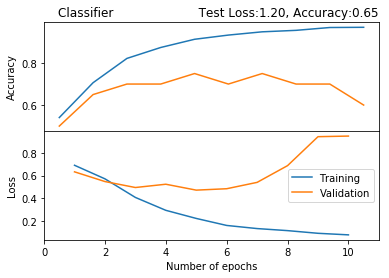

In [63]:
print_acc_loss_plot(len(history.history['val_loss']), history.history, 'Classifier', test_eval)

Right after second epoch, the validation loss started increasing which tells us our ideal number of epochs is 4 to be on safe side

#### E. Make Predictions

Feel free to write your own sentences and see how model performs

In [53]:
test_texts = ['bad service', 
              'good service', 
              'I think the food is bad', 
              'if only food was good', 
              'beautiful but bad', 
              'good food',
              'the good food',
              'love good food',
              'love the good food']
test_labels = [0, 1, 0, 0, 0, 1, 1, 1, 1]

print("\033[1m{:<30}{:<10}{:<10}\033[0m".format("Text", "True", "Predicted"))
for tst, label in zip(test_texts, test_labels):
    tsti = pad_sequences(tokenizer.texts_to_sequences(tst), maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')
    predictions = model.predict(tsti, verbose=0)
    print("{:<30}{:<10}{:<10}".format(tst, reverse_sentiments[label], reverse_sentiments[int(np.round(predictions[0])[0])]))

Text                          True      Predicted 
bad service                   NEGATIVE  NEGATIVE  
good service                  POSITIVE  NEGATIVE  
I think the food is bad       NEGATIVE  NEGATIVE  
if only food was good         NEGATIVE  NEGATIVE  
beautiful but bad             NEGATIVE  NEGATIVE  
good food                     POSITIVE  NEGATIVE  
the good food                 POSITIVE  NEGATIVE  
love good food                POSITIVE  NEGATIVE  
love the good food            POSITIVE  NEGATIVE  


We should use a confusion matrix but even without that above results are $40\%$ accurate.

#### F. Memory Cleanup

In [342]:
%xdel model

## 4. Evaluate different Hyperparamters on Sentiment Classifier built in Step 3


### A. Activation Function

In [64]:
activations = ['tanh', 'relu', 'elu', 'selu', 'sigmoid', 'softplus']

In [65]:
histories, titles, test_evals, megatitle = [], [], [], 'activation functions'

In [66]:
for activation in activations:
    print("Evaluating for", activation)
    model = get_single_layer_lstm_model(activation=activation)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_set, train_label, epochs=EPOCHS, batch_size=128, shuffle=True, verbose=0,
                               validation_data=(validation_set, validation_label), callbacks=[])
    histories.append(history.history)
    titles.append(activation)
    test_evals.append(model.evaluate(test_set, test_label, batch_size=500, verbose=0))
    
#     print_plot(epochs, history.history, 'Activation Function: '+activation, test_eval )
    %xdel model

Evaluating for tanh
Evaluating for relu
Evaluating for elu
Evaluating for selu
Evaluating for sigmoid
Evaluating for softplus


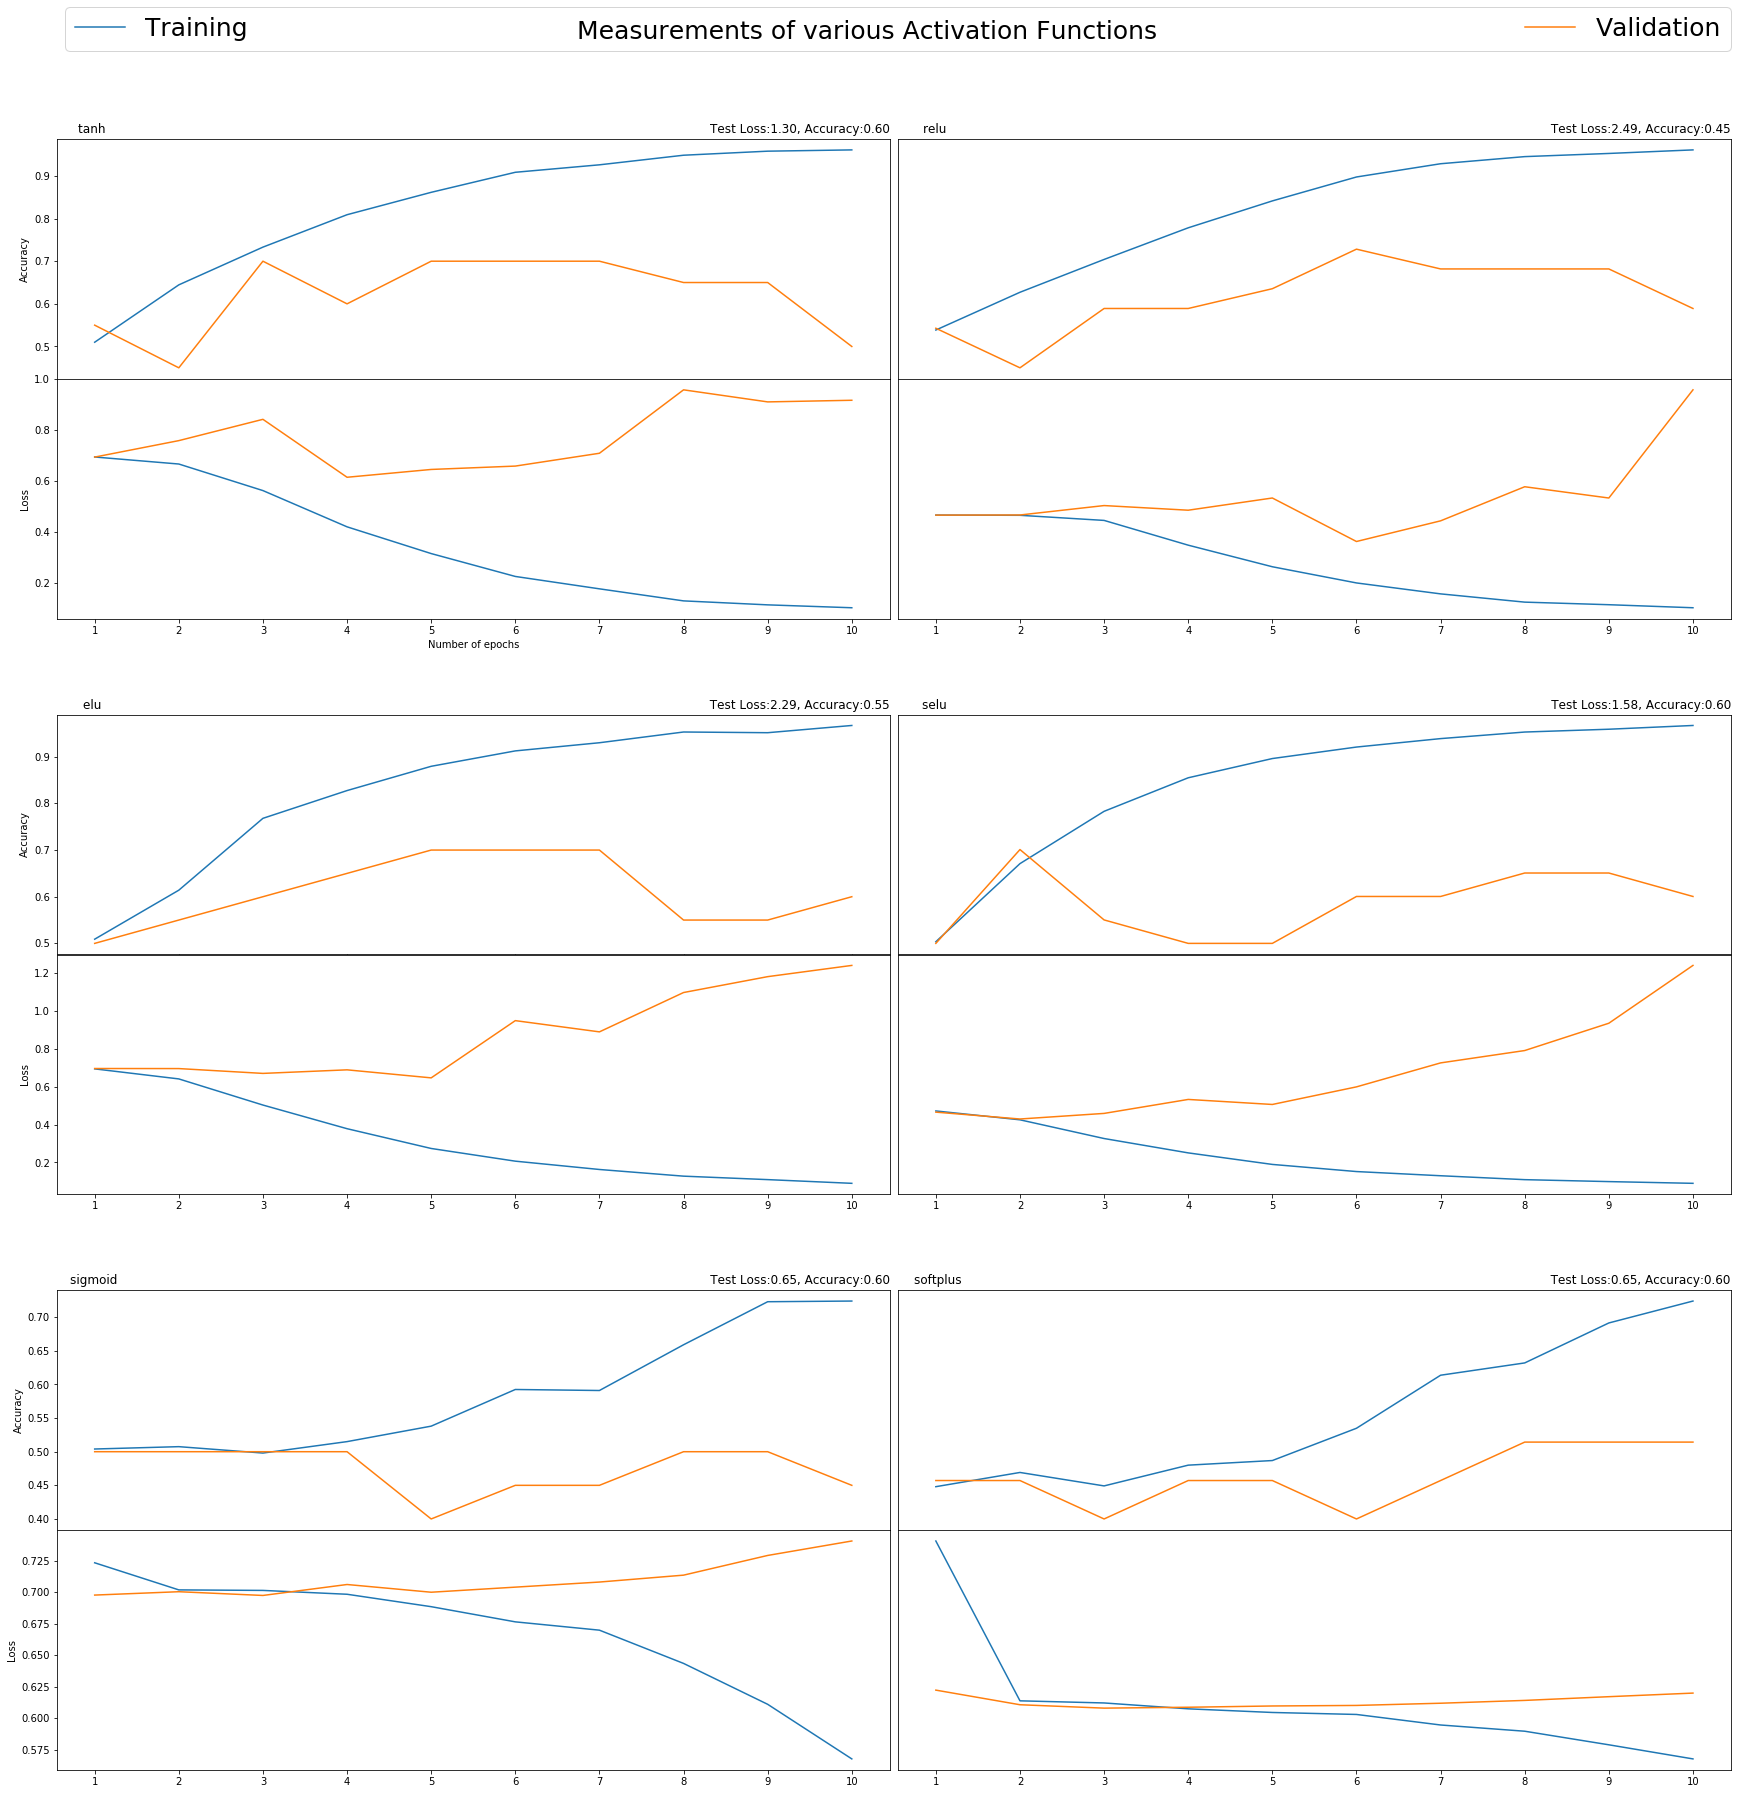

In [67]:
show_grid(EPOCHS, histories, titles, test_evals, megatitle)

**How does changing the activation function effect the accuracy?**<br>
Since our goal here is a binary classification, any other activation function needs something that can give 0 or 1 as output for which *sigmoid* is the way to go. <br> 
Even though we could've used `softmax` over *positive* and *negative* class with `categorical_entropy` but that would've been better suited for a multi-class classification that will give us probability distribution over all the classes and then taking an argmax over the distribution would give us most likely class.<br>
**elu** gave us the highest accuracy, but still the variance in accuracy over various activation functions applied here.

**How does it effect how quickly the network plateaus?**<br>
Decreasing order of network plateaus:
1. tanh
2. softplus
3. sigmoid
4. elu
5. selu
6. relu

Various activation functions:
- Rectified linear unit (ReLU)
- TanH
- Leaky rectified linear unit (Leaky ReLU)
- Parameteric rectified linear unit (PReLU)
- Randomized leaky rectified linear unit (RReLU)
- Exponential linear unit (ELU)
- Scaled exponential linear unit (SELU)
- S-shaped rectified linear activation unit (SReLU)
- Identity
- Binary step
- Logistic
- ArcTan
- Softsign
- Adaptive piecewise linear (APL)
- SoftPlus
- SoftExponential
- Sinusoid
- Sinc
- Gaussian

### B. Cost Function

In [68]:
costs = ['binary_crossentropy', 'mean_squared_error', 'squared_hinge', 
         'logcosh', 'kullback_leibler_divergence', 'cosine_proximity']

In [80]:
histories, titles, test_evals, megatitle = [], [], [], 'cost functions'

In [81]:
for cost in costs:
    print("Evaluating for", cost)
    model = get_single_layer_lstm_model(activation='elu')
    model.compile(optimizer='adam', loss=cost, metrics=['accuracy'])
    history = model.fit(train_set, train_label, epochs=EPOCHS, batch_size=128, shuffle=True, verbose=0,
                               validation_data=(validation_set, validation_label), callbacks=[])
    histories.append(history.history)
    titles.append(cost)
    test_evals.append(model.evaluate(test_set, test_label, batch_size=500, verbose=0))
    
#     print_plot(epochs, history.history, 'Activation Function: '+activation, test_eval )
    %xdel model

Evaluating for binary_crossentropy
Evaluating for mean_squared_error
Evaluating for squared_hinge
Evaluating for logcosh
Evaluating for kullback_leibler_divergence
Evaluating for cosine_proximity


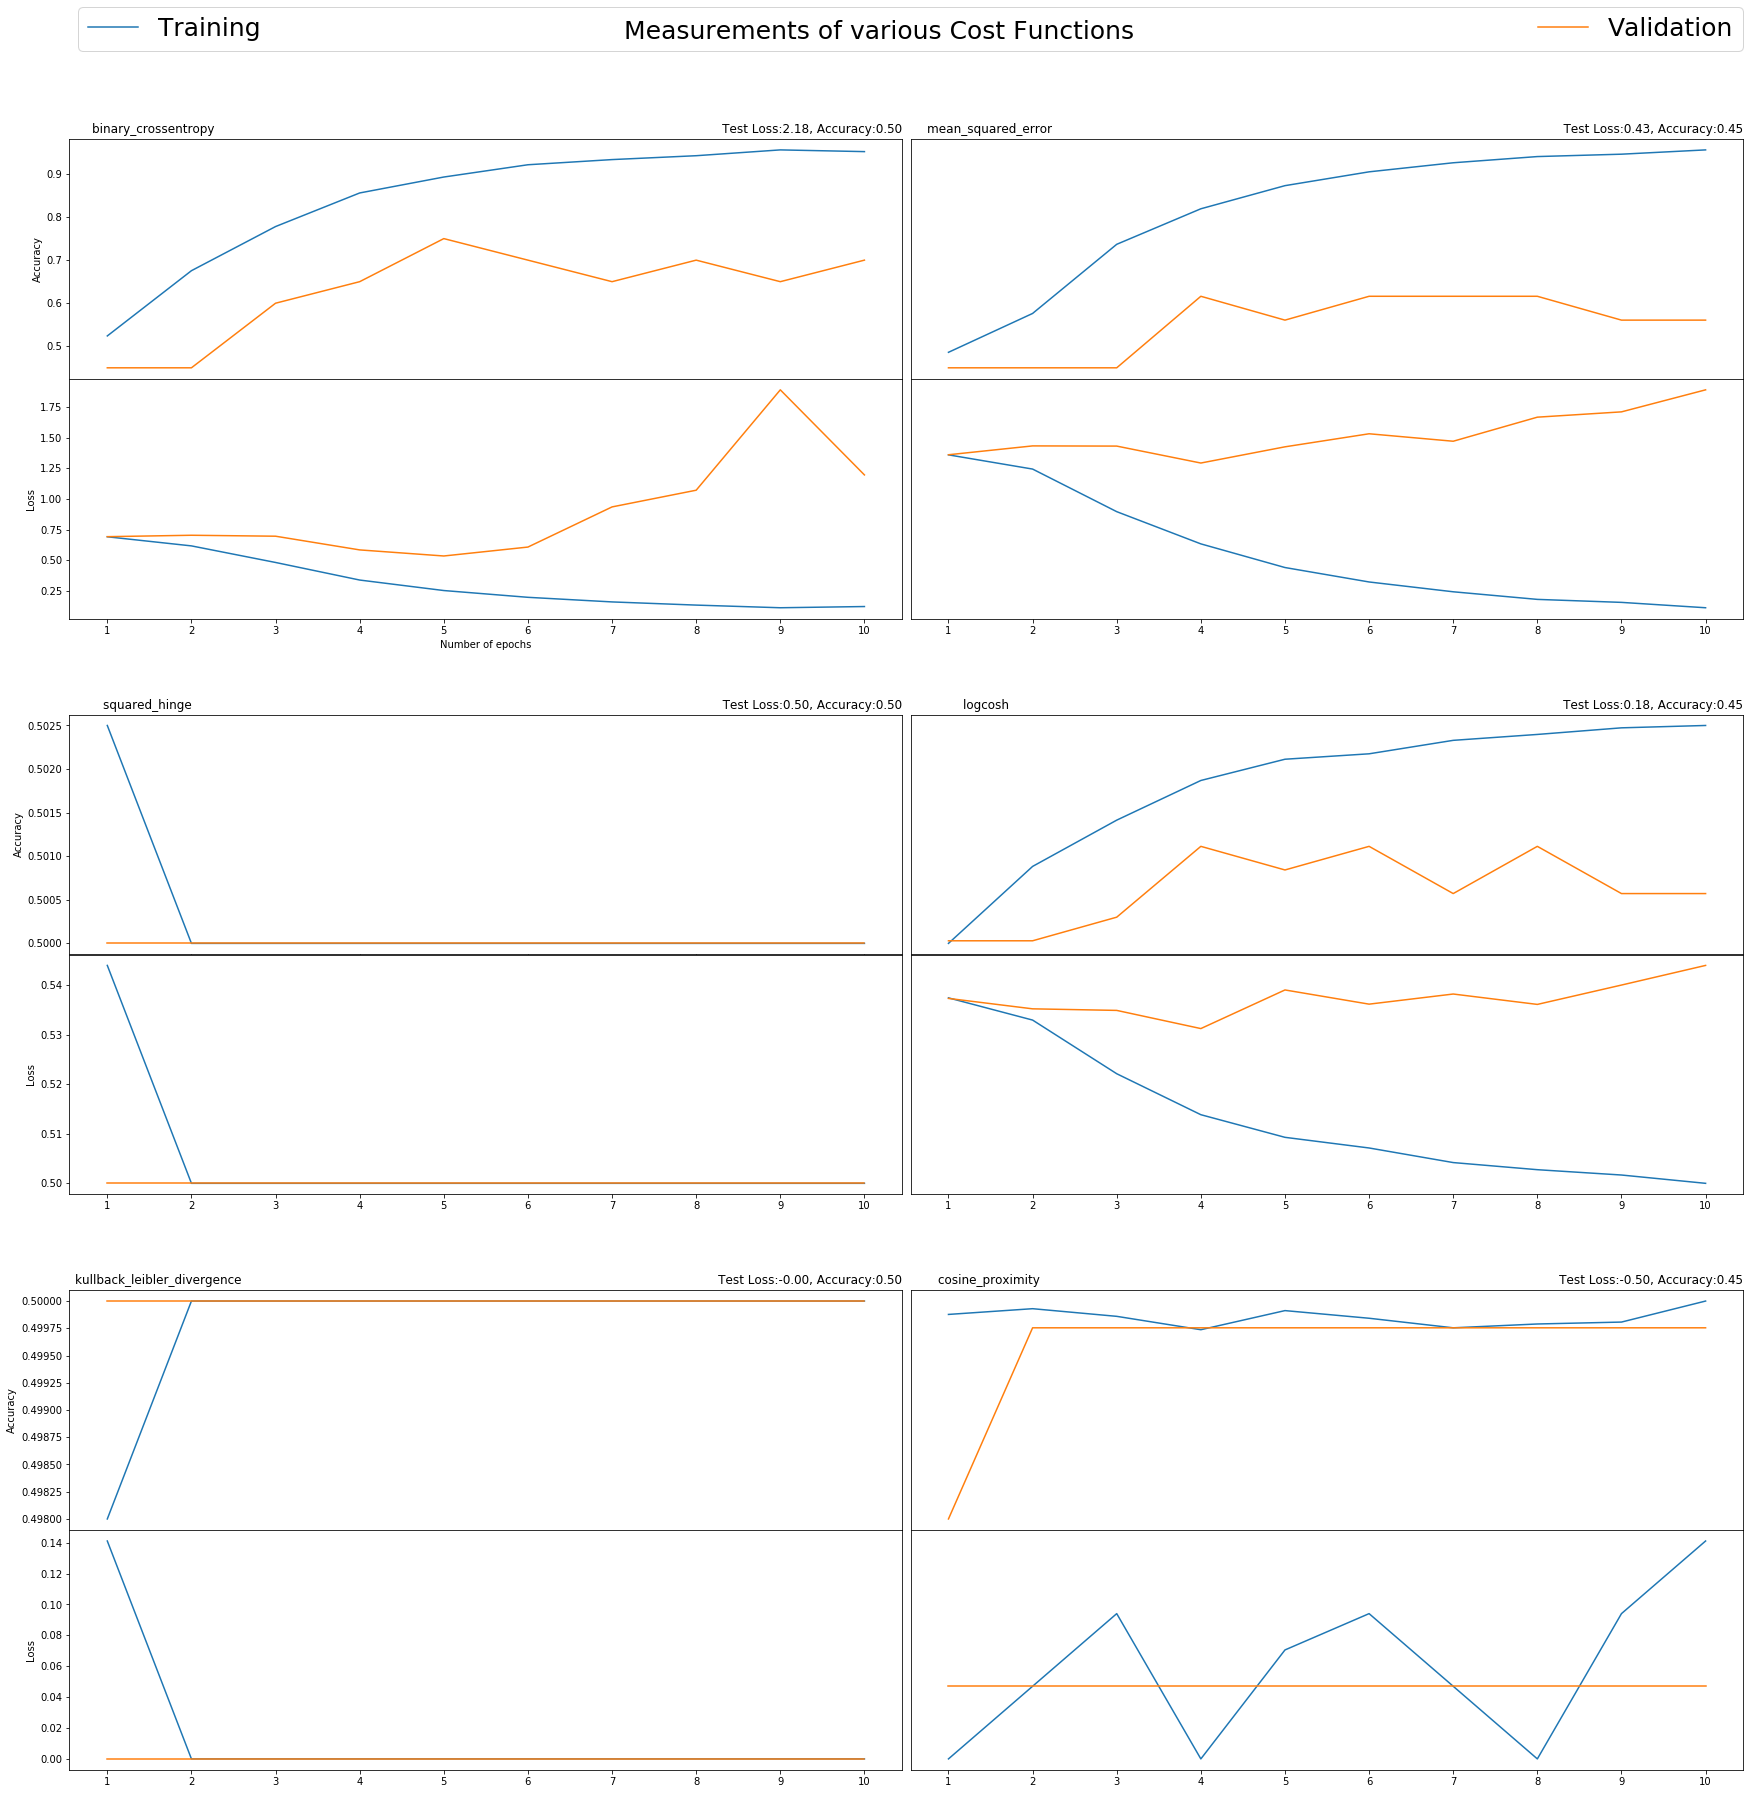

In [86]:
show_grid(EPOCHS, histories, titles, test_evals, megatitle)

**Change the cost function. How does it effect the accuracy?**<br>
Changing cost has a huge impact on accuracy in some of the functions such as hinge and KL divergence. `mean_squared_error` is highly suitable for RNNs which is evident from graph, `binary_crossentropy` is best of 0/1 decisions which is evident as it gives us the highest accuracy.

**How does it effect how quickly the network plateaus?**<br>
It highly affects how the network plateaus 
- `squared_hinge` was steep in after every epoch and was either at top accuracy or lowest. 
- `kullback_leibler_divergence` dropped into a local minima and never got out of that while `cosine_proximity` keeps jumping in and out of minima.
- `mean_squared_error` and `logcosh` are close to optimal and plateaus evenly after 9th epoch.
- `binary_crossentropy` gives us highest validation accuracy at around 5 epochs.

### C. Epochs

In [87]:
epochs = [10, 20, 30, 50, 100]

In [93]:
histories, titles, test_evals, megatitle = [], [], [], 'epochs'

Evaluating for 10 epochs


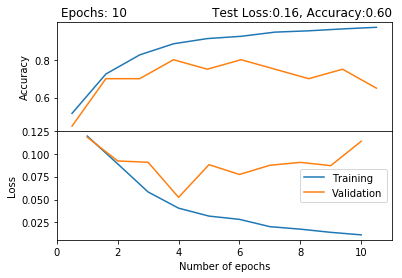

Evaluating for 20 epochs


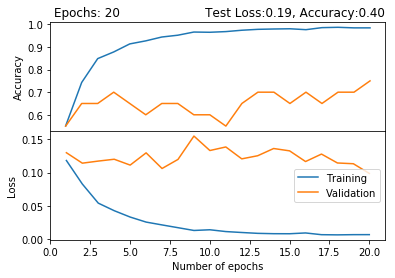

Evaluating for 30 epochs


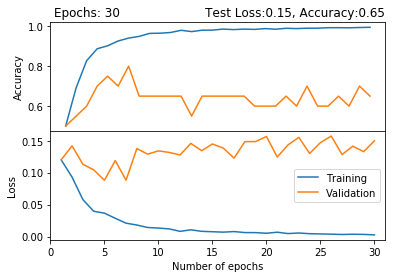

Evaluating for 50 epochs


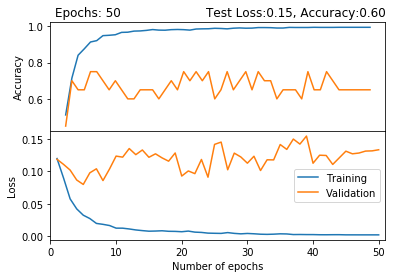

Evaluating for 100 epochs


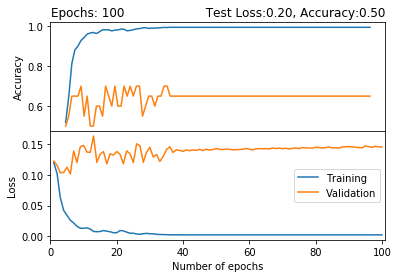

In [95]:
for epoch in epochs:
    # print('Evaluating for', epoch, "epochs")
    model = get_single_layer_lstm_model(activation='elu')
    model.compile(optimizer='adam', loss='logcosh', metrics=['accuracy'])
    history = model.fit(train_set, train_label, epochs=epoch, batch_size=BATCH_SIZE,
                       validation_data=(validation_set, validation_label), shuffle=True, verbose=0)
    histories.append(history.history)
    titles.append(str(epoch) + " epochs")
    test_eval = model.evaluate(test_set, test_label, batch_size=500, verbose=0)
    test_evals.append(test_eval)
    print_acc_loss_plot(epoch, history.history, 'Epochs: ' + str(epoch), test_eval )
    %xdel model

**Change the number of epochs initialization. How does it effect the accuracy?** <br>
Increasing number of epochs using *adam* optimizer and *logcosh* cost functions did not increase accuracy rather it is less than small number of epochs but

**How does it effect how quickly the network plateaus?** <br>
The network reaches global optima around 45th epoch after which validation accuracy and test loss remained the same.

### E. Gradient Estimation

In [126]:
optimizers = ['sgd', 'adagrad', 'rmsprop', 'adam', 'nadam', 'adadelta']

In [127]:
histories, titles, test_evals, megatitle = [], [], [], 'optimizers'

In [128]:
for optimizer in optimizers:
    print('Evaluating for', optimizer)
    model = get_single_layer_lstm_model(activation='elu')
    model.compile(optimizer=optimizer, loss='logcosh', metrics=['accuracy'])
    history = model.fit(train_set, train_label, epochs=EPOCHS, batch_size=BATCH_SIZE,
                       validation_data=(validation_set, validation_label), shuffle=True, verbose=0)
    histories.append(history.history)
    titles.append(optimizer)
    test_eval = model.evaluate(test_set, test_label, batch_size=500, verbose=0)
    test_evals.append(test_eval)
#     print_acc_loss_plot(epoch, history.history, 'Epochs: ' + str(epoch), test_eval )
    %xdel model

Evaluating for sgd
Evaluating for adagrad
Evaluating for rmsprop
Evaluating for adam
Evaluating for nadam
Evaluating for adadelta


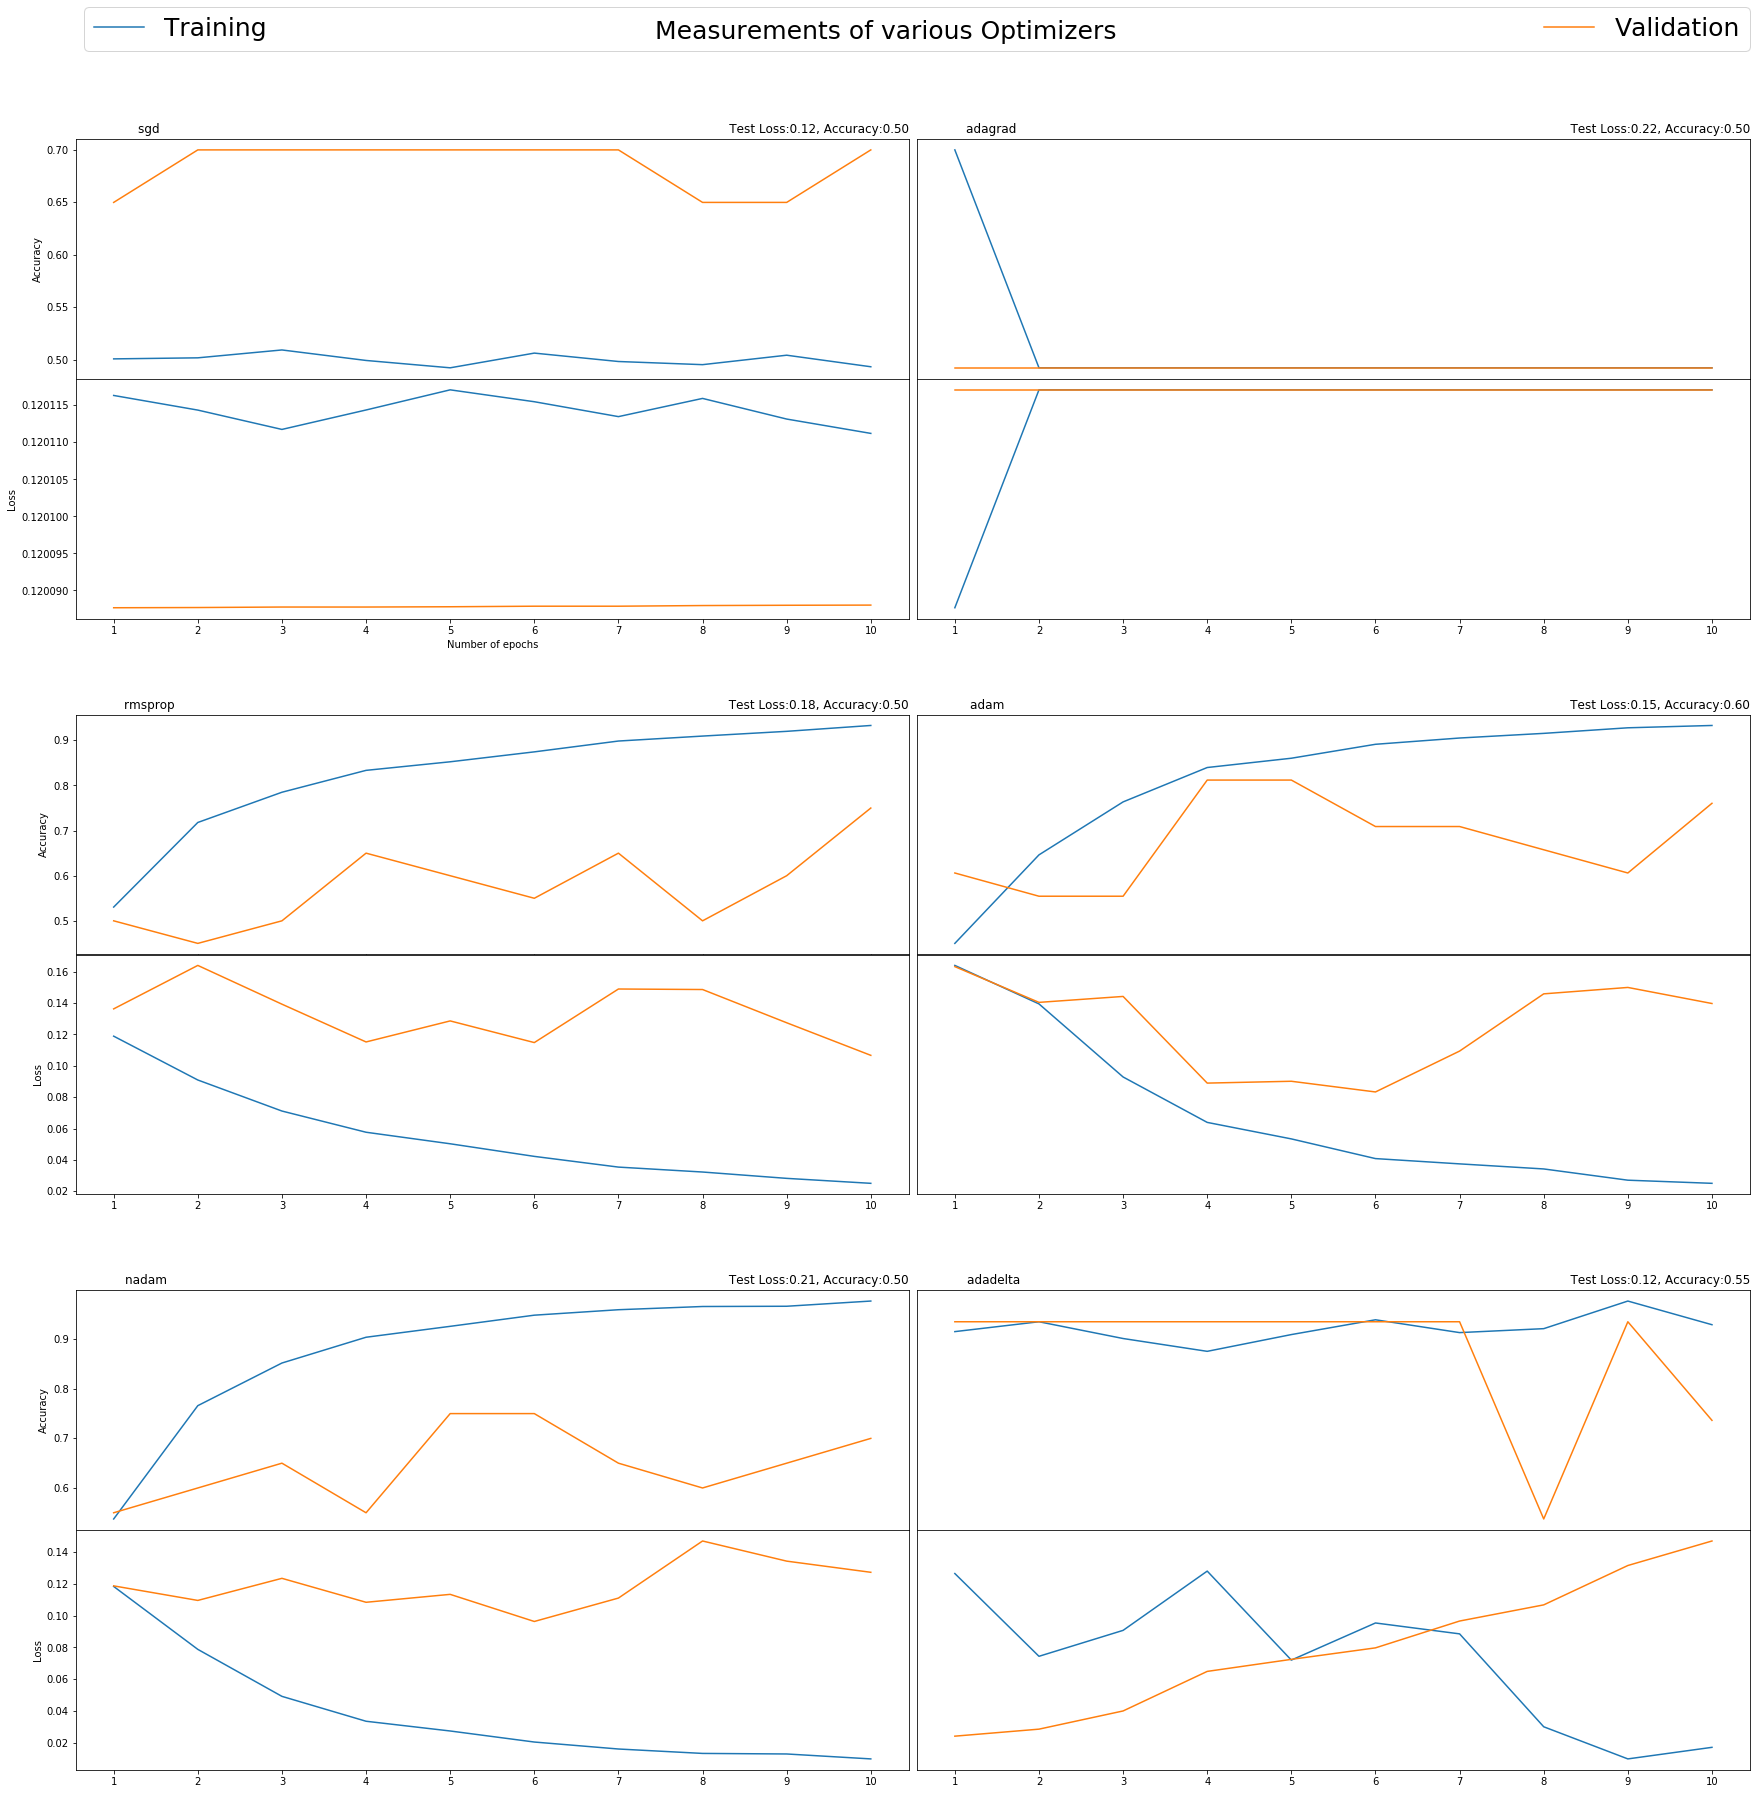

In [129]:
show_grid(EPOCHS, histories, titles, test_evals, megatitle)

**Change the number of gradient estimation. How does it effect the accuracy?**<br>
Changing gradient estimation affects how quickly we get to the optimal accuracy measure. `Adadelta` crossed even though highly variant in searching for optima led us to the highest accuracy of 0.55 with a test loss of 0.12 comparable to `sgd` which is equivalent and stable.

**How does it effect how quickly the network plateaus?**<br>
SGD notably did not even make the network plateau in 10 epochs and was very unstable.

Decreasing epochs each estimator took to make the network plateau:
1. RMSProp
2. Nadam (Nesterov Adam: Much like Adam is essentially RMSprop with momentum, Nadam is Adam RMSprop with Nesterov momentum.)
3. Adam
4. Adagrad
4. Adadelta
5. SGD (Stochastic Gradient Descent)

### F. Network Architecture

Various forms of network architecture:
- Number of layers
- Size of each layer
- Connection type
- Pre-trained components e.g. word-embeddings or weights if state of art models but we won't be covering that part.

In [124]:
def compile_summarize_fit_eval_plot_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(train_set, train_label, 
                        epochs=100, 
                        batch_size=500,
                        shuffle=True,
                        validation_data=(validation_set, validation_label), 
                        verbose=0)
    test_eval = model.evaluate(test_set, test_label, batch_size=500, verbose=0)
    print_acc_loss_plot(100, history.history, '', test_eval)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_84 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
gru_27 (GRU)                 (None, 512)               803328    
_________________________________________________________________
dropout_94 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 513       
Total params: 903,851
Trainable params: 903,851
Non-trainable params: 0
_________________________________________________________________


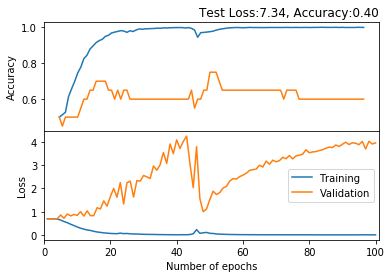

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_85 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
gru_28 (GRU)                 (None, 512)               803328    
_________________________________________________________________
dropout_95 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 513       
Total params: 903,851
Trainable params: 903,851
Non-trainable params: 0
_________________________________________________________________


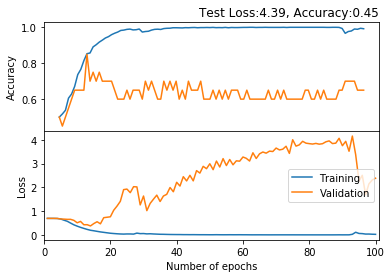

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_86 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 1024)              1606656   
_________________________________________________________________
dropout_96 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 1025      
Total params: 1,707,691
Trainable params: 1,707,691
Non-trainable params: 0
_________________________________________________________________


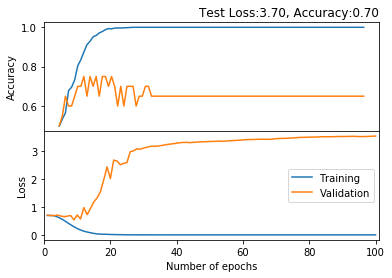

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_87 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 1024)              1606656   
_________________________________________________________________
dropout_97 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 1025      
Total params: 1,707,691
Trainable params: 1,707,691
Non-trainable params: 0
_________________________________________________________________


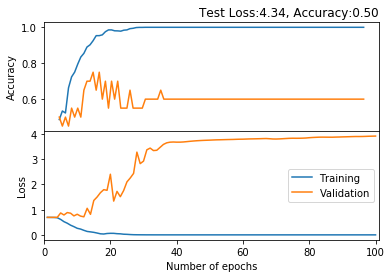

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
lstm_68 (LSTM)               (None, 10, 512)           1071104   
_________________________________________________________________
dropout_98 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_99 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 513       
Total params: 3,270,827
Trainable params: 3,270,827
Non-trainable params: 0
_________________________________________________________________


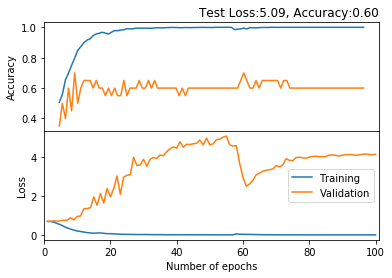

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_89 (Embedding)     (None, 10, 10)            100010    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 10, 1024)          2142208   
_________________________________________________________________
dropout_100 (Dropout)        (None, 10, 1024)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dropout_101 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 1025      
Total params: 8,538,795
Trainable params: 8,538,795
Non-trainable params: 0
_________________________________________________________________


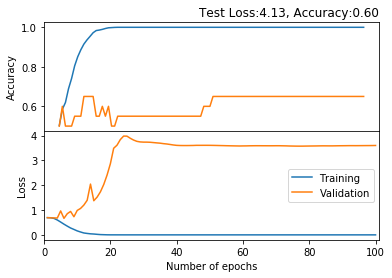

In [125]:
for model in [get_single_layer_gru_model(),
              get_single_layer_gru_model(),
              get_single_layer_gru_model(bidirectional=True),
              get_single_layer_gru_model(bidirectional=True),
              get_double_layer_lstm_model(),
              get_double_layer_bdlstm_model()]:
    compile_summarize_fit_eval_plot_model(model)
    %xdel model

Note: A model is used twice above, and even after that look at how different it's performance is, there reason behind that is the random initialization of RNN. This could be fixed by passing a seed.

**Change the number of network architecture. How does it effect the accuracy?**<br>
Changing network architectures affect test loss more than accuracy here since most of the systems reached global optima on training set by 20th epoch. Another thing to notice is that even with the increase in more layers, the most naive of all (the first network) came out as a strong contender vs deep networks of bidirectional double layered with more number of layers. Best guess is double layers are indeed better at capturing but given that we have fixed number of epochs, so *occam's razor* is best used here.

**How does it effect how quickly the network plateaus?**<br>
Increasing depth of network slowed network plateau while having a bidirectional layer equally plateaud as unidirectional layers.

### G. Network Initialization

Various forms of network initialization:
- 0
- Uniform
- Gaussian
- Xavier Glorot Initialization http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
- Xavier Uniform
- Xavier Gaussian

In [108]:
initializers = ['zeros', 'ones', 'random_uniform', 'lecun_uniform', 'glorot_normal', 'glorot_uniform']

In [114]:
histories, titles, test_evals, megatitle = [], [], [], 'initializers'

In [115]:
for initializer in initializers:
    print('Evaluating initializer: ', initializer)
    model = get_single_layer_gru_model(activation='elu', initializer=initializer)
    model.compile(optimizer='adam', loss='logcosh', metrics=['accuracy'])
    history = model.fit(train_set, train_label, epochs=EPOCHS, batch_size=BATCH_SIZE,
                       validation_data=(validation_set, validation_label), shuffle=True, verbose=0)
    histories.append(history.history)
    titles.append(initializer)
    test_eval = model.evaluate(test_set, test_label, batch_size=500, verbose=0)
    test_evals.append(test_eval)
#     print_acc_loss_plot(epoch, history.history, 'Epochs: ' + str(epoch), test_eval )
    %xdel model

Evaluating initializer:  zeros
Evaluating initializer:  ones
Evaluating initializer:  random_uniform
Evaluating initializer:  lecun_uniform
Evaluating initializer:  glorot_normal
Evaluating initializer:  glorot_uniform


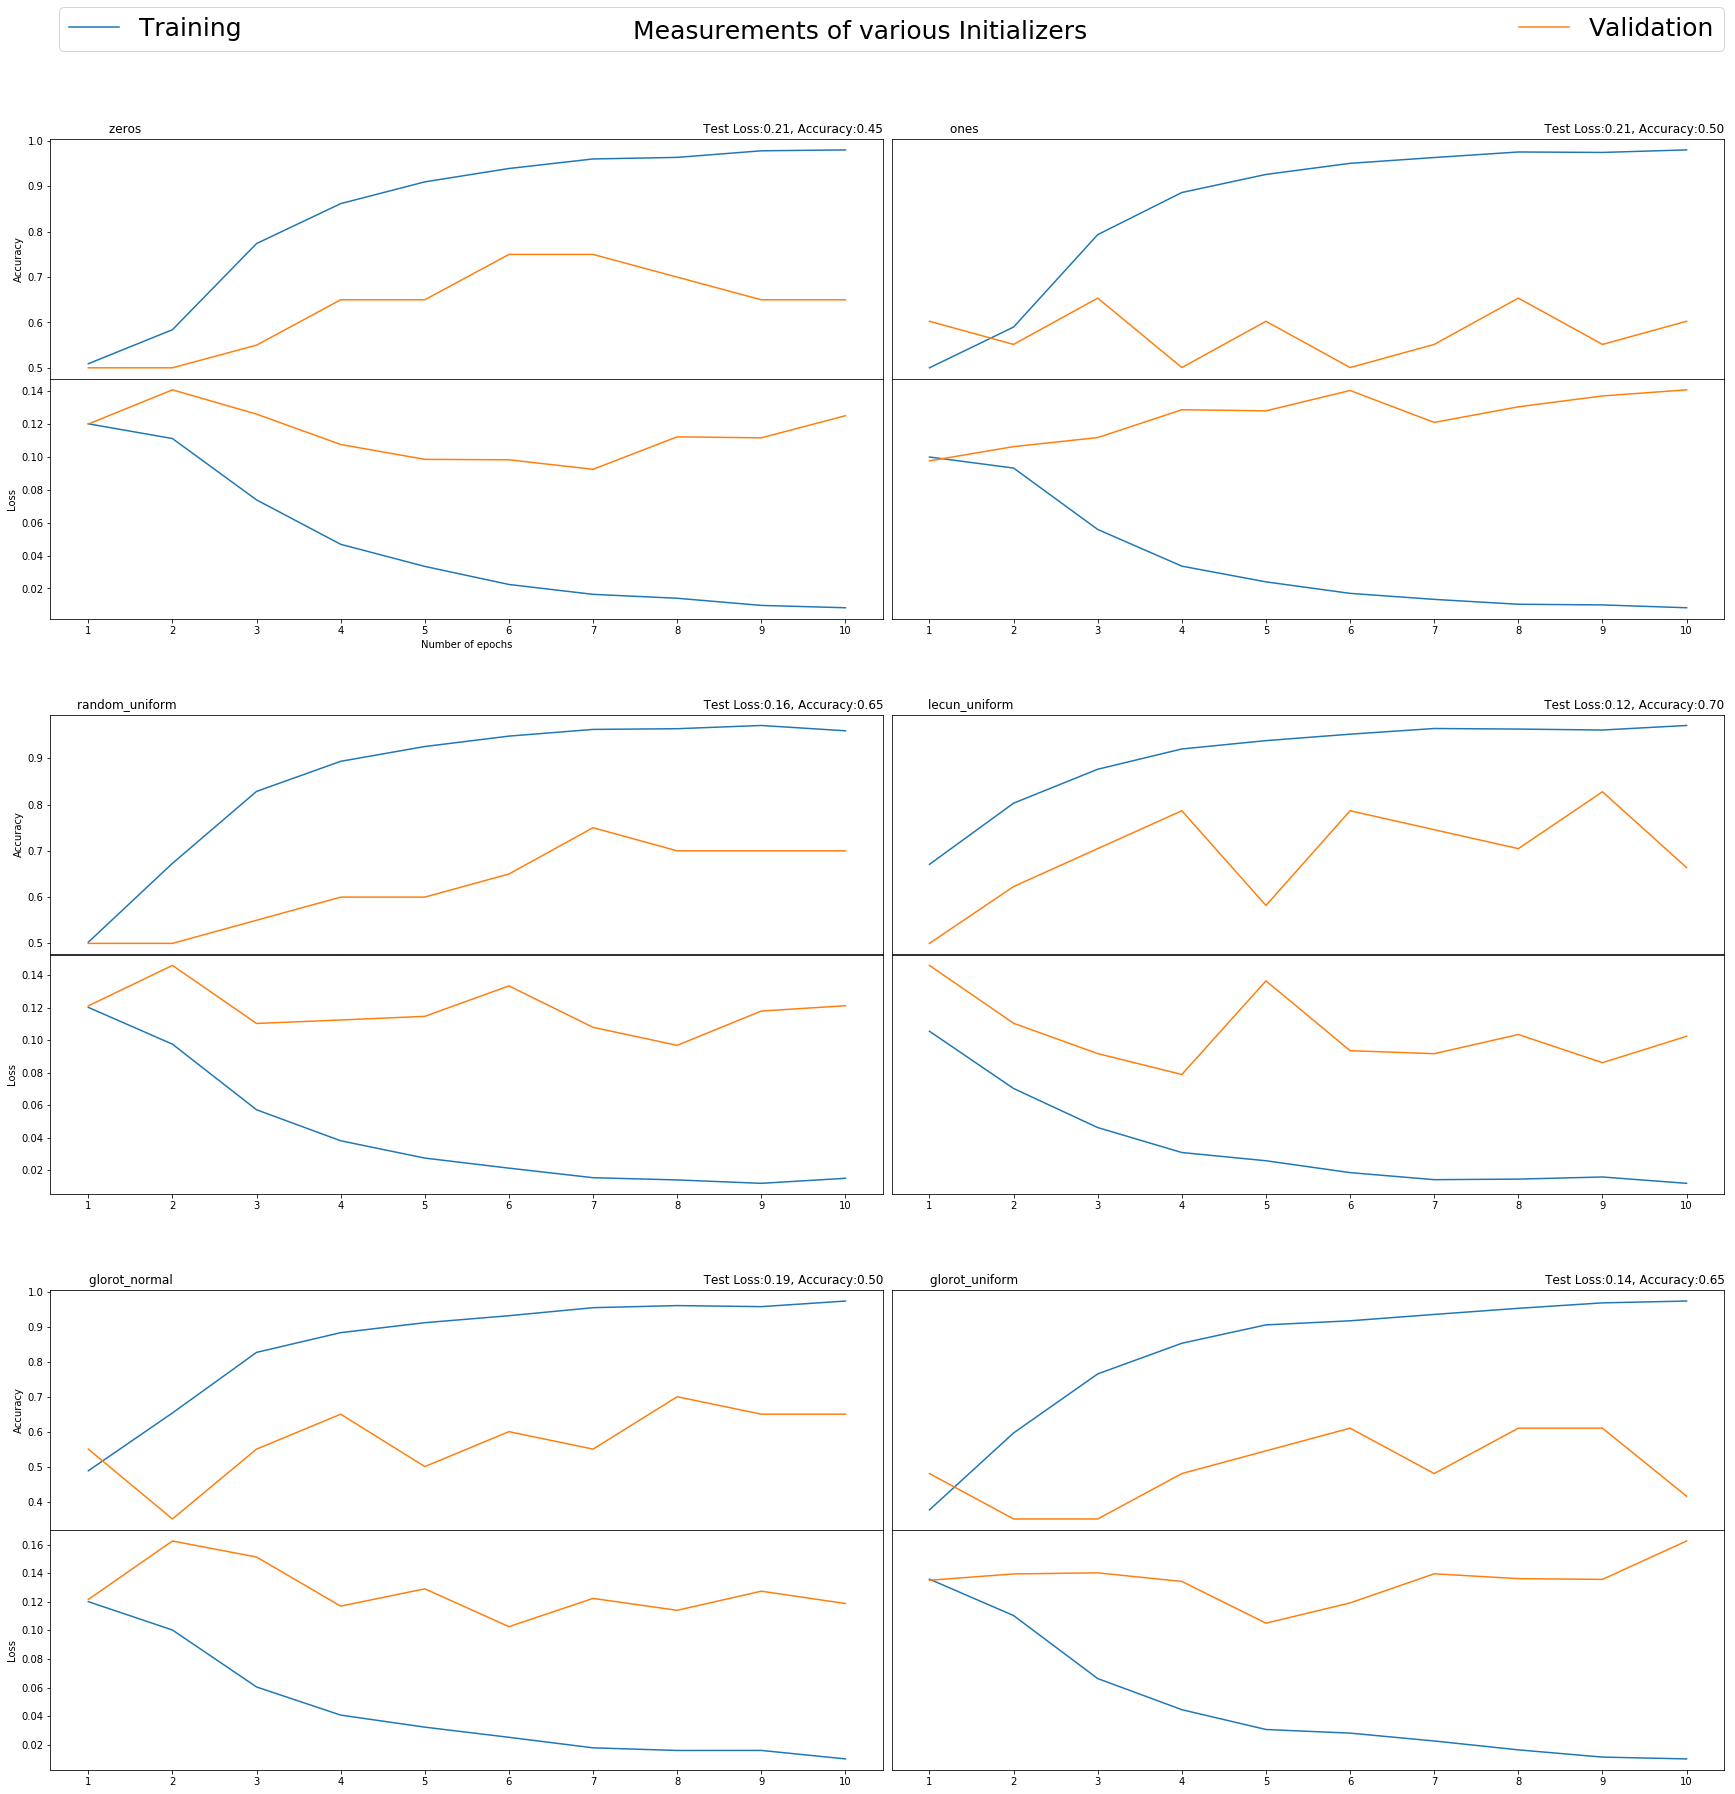

In [116]:
show_grid(EPOCHS, histories, titles, test_evals, megatitle)

**Change the number of network initialization. How does it effect the accuracy?**<br>
Changing initialization affect the accuracy alot in this network, as we see `zeros` gave us the lowest test loss and second highest accuracy but it's validation accuracy remained consistent all througout the training. Contrary to expectation from `glorot_uniform`, `ones` gave us the best accuracy and more than double the loss vs `zeros`.

**How does it effect how quickly the network plateaus?**<br>
Except `zeros` which was still unstable at 10th epoch, changing initialization does not affect the plateau much as we saw in the graphs that all except `zeros` plateaud fairly well by the end of 10th epoch.

## Conclusion
I'm sure there are a lot of observations I might have missed, please feel free to fork the notebook on [github]() or simply mention in the comments.

## Thank You for your patience and thanks to @NikBearBrown for giving the idea to try out various parameters.